# Open Exploration Rijkswaterstaat Random Sampling Analysis Notebook

In this notebook experiments conducted in 'RWS_OpenExploration_RandomSampling_Experiments.ipynb' are analysed. These results and experiments are saved in the result folder. 

***

**Content**
1. Importing packages
2. Load results, experiments and outcomes
3. Visual Analysis
4. Scenario Discovery using PRIM
5. Feature Scoring
6. Regional sensitivity analysis

***

### 1 | Importing packages

Start with importing the packages that are needed to complete the open exlporation. This includes more general packages and more specific packages from, for instance, the EMA workbench.

***



In [3]:
#Import necessary packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import altair as alt

In [4]:
#Import necessary packages, functions

from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter, save_results, load_results)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import feature_scoring, prim, dimensional_stacking, pairs_plotting

from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import ema_workbench.em_framework.samplers
from SALib.analyze import sobol
from SALib.sample import saltelli, morris, fast_sampler
import SALib.util.results
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import prim


from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

def sum_over(*args):
    return sum(args)

### 2 | Load results, experiments and outcomes

***

In [5]:
#Load results
results = load_results('./results/open_exploration_rijks_PF2.tar.gz')  

[MainProcess/INFO] results loaded succesfully from C:\Users\kempe\OneDrive\Documents\MSc Engineering and Policy Analysis\EPA 1361 Model Based Decision making\Model_based\final assignment\results\open_exploration_rijks_PF2.tar.gz


In [6]:
#create different tuple for the results
experiments, outcomes = results

In [7]:
#check the outcome dataframe
outcomes

{'Expected Annual Damage': array([19805838.18683221,        0.        ,        0.        , ...,
         4713526.3525082 , 38130393.53462088,  4616130.84635046]),
 'Dike Investment Costs': array([5.09743811e+08, 5.09743811e+08, 5.09743811e+08, ...,
        4.51662695e+08, 4.51662695e+08, 4.51662695e+08]),
 'RfR Investment Costs': array([1.3518e+09, 1.3518e+09, 1.3518e+09, ..., 1.0570e+09, 1.0570e+09,
        1.0570e+09]),
 'Evacuation Costs': array([ 430.70058482,    0.        ,    0.        , ...,  364.47548686,
        3051.07768732,  354.40848116]),
 'Expected Number of Deaths': array([0.00562873, 0.        , 0.        , ..., 0.00066681, 0.00481018,
        0.00065849])}

In [8]:
#check the experiment dataframe
experiments

A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                        127.0  237.843044       1.0   0.931498  321.517120   
1                         26.0  188.409051       1.5   0.663340   66.471071   
2                         17.0  298.897002      10.0   0.259531   78.117773   
3                         15.0  148.587021       1.5   0.628690  337.238115   
4                         82.0   96.223527       1.5   0.479539   37.701638   
...                        ...         ...       ...        ...         ...   
12495                     24.0  232.945508      10.0   0.315375   55.273448   
12496                     10.0  189.227253       1.5   0.272402  342.890462   
12497                      4.0   50.760634       1.5   0.691757  260.123399   
12498                     65.0  311.463122       1.5   0.643961  126.067143   
12499                     71.0  250.022803      10.0   0.230724  242.932852   

      A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
0           1.0   0.239127  185.780793       1.0   0.607330  ...   
1           1.0   0.619709  331.559291      10.0   0.529344  ...   
2          10.0   0.945546  114.837322      10.0   0.921692  ...   
3           1.5   0.027454  136.359048      10.0   0.223969  ...   
4           1.5   0.730923  207.449317       1.5   0.586327  ...   
...         ...        ...         ...       ...        ...  ...   
12495      10.0   0.806061  223.016341       1.5   0.174292  ...   
12496      10.0   0.926713  160.144052       1.0   0.962969  ...   
12497       1.5   0.822008  143.361624       1.5   0.115498  ...   
12498      10.0   0.433921   30.112689       1.5   0.566320  ...   
12499      10.0   0.712903  167.607529       1.0   0.730555  ...   

       A.4_DikeIncrease 0 A.4_DikeIncrease 1  A.4_DikeIncrease 2  \
0                     6.0                8.0                 8.0   
1                     6.0                8.0                 8.0   
2                     6.0                8.0                 8.0   
3                     6.0                8.0                 8.0   
4                     6.0                8.0                 8.0   
...                   ...                ...                 ...   
12495                 1.0                6.0                 1.0   
12496                 1.0                6.0                 1.0   
12497                 1.0                6.0                 1.0   
12498                 1.0                6.0                 1.0   
12499                 1.0                6.0                 1.0   

       A.5_DikeIncrease 0 A.5_DikeIncrease 1  A.5_DikeIncrease 2  \
0                    10.0                7.0                 0.0   
1                    10.0                7.0                 0.0   
2                    10.0                7.0                 0.0   
3                    10.0                7.0                 0.0   
4                    10.0                7.0                 0.0   
...                   ...                ...                 ...   
12495                 0.0                2.0                 7.0   
12496                 0.0                2.0                 7.0   
12497                 0.0                2.0                 7.0   
12498                 0.0                2.0                 7.0   
12499                 0.0                2.0                 7.0   

      EWS_DaysToThreat scenario policy     model  
0                  1.0        0      0  dikesnet  
1                  1.0        1      0  dikesnet  
2                  1.0        2      0  dikesnet  
3                  1.0        3      0  dikesnet  
4                  1.0        4      0  dikesnet  
...                ...      ...    ...       ...  
12495              4.0      245     49  dikesnet  
12496              4.0      246     49  dikesnet  
12497              4.0      247     49  dikesnet  
12498              4.0      248     49  dikesnet  
12499              4.0      249     49  dikesn

### 3 | Visual Analysis
In this section an visual analysis will be conducted. 

***

[MainProcess/INFO] no time dimension found in results


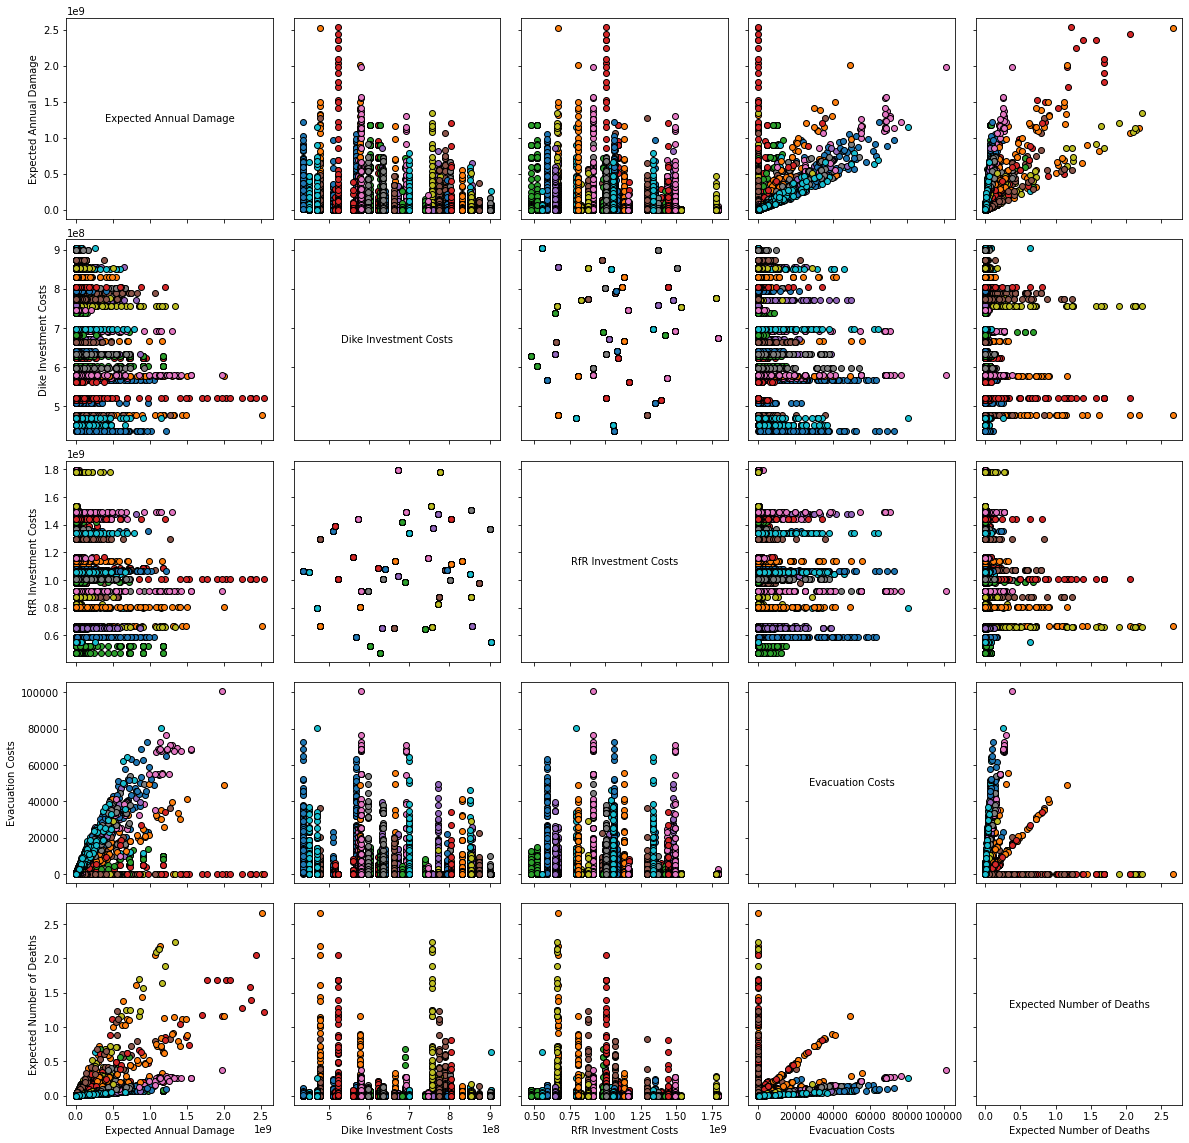

In [9]:
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy',
                                         legend=False)
fig.set_size_inches(20,20)
plt.show()

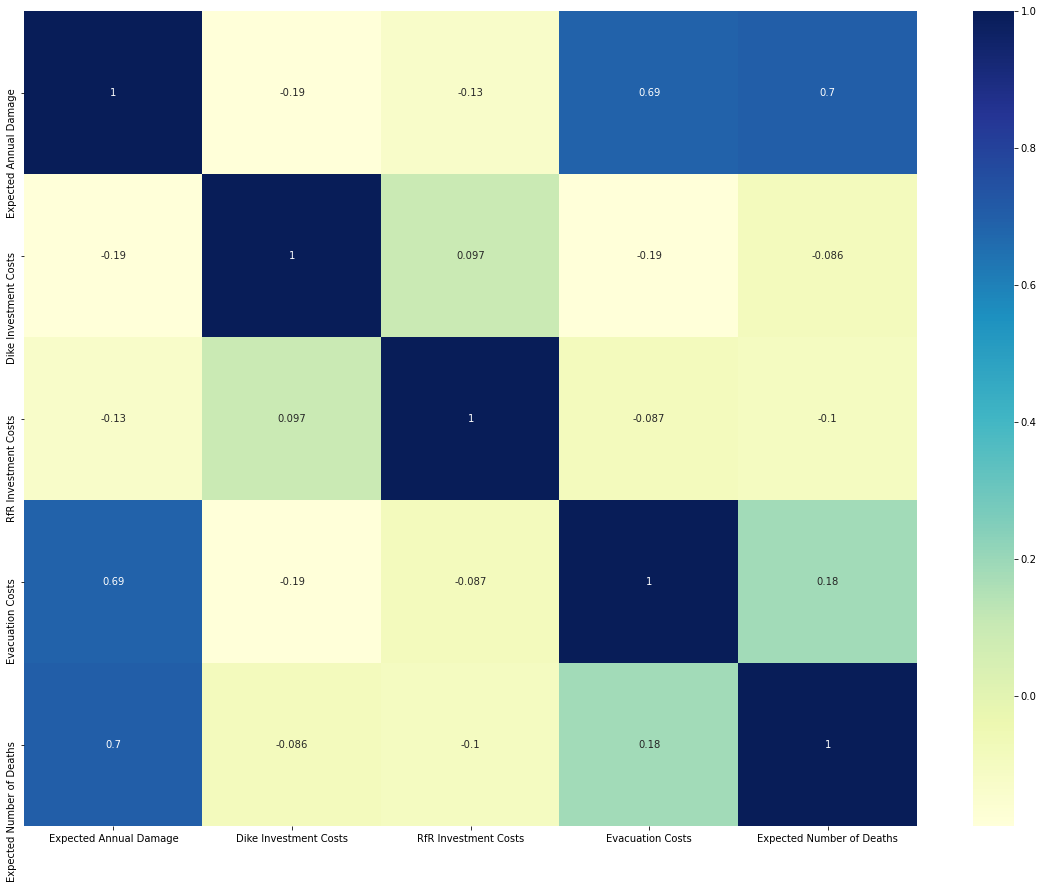

In [10]:
#Correlation matrix which show the correlations between outcomes
outcomes_df = pd.DataFrame(outcomes)
corr_df = outcomes_df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr_df, annot=True, cmap="YlGnBu")

# plt.savefig("./results/correlations_RWS_refpolicy.jpg", bbox_inches="tight")
plt.show()

### 4 | Scenario Discovery using PRIM

PRIM scenario discovery is conducted to identify the combinations of levers and uncertainties that result in the worst case scenarios for Rijkswaterstaat. Even though all the outcomes of interest can be analysed separately, for the report the PRIM analysis has been executed for the top 80 percentile of expected deaths for all the different number 

***

In [11]:
# # Define outcomes

# outcomes['Total Expected Number of Deaths'] = (outcomes['A.1_Expected Number of Deaths'] + 
#                                                outcomes['A.2_Expected Number of Deaths'] +
#                                                outcomes['A.3_Expected Number of Deaths'] +
#                                                outcomes['A.4_Expected Number of Deaths'] +
#                                                outcomes['A.5_Expected Number of Deaths']
#                                               )

# outcomes['Total Costs'] = (              outcomes['A.1 Total Costs'] + 
#                                          outcomes['A.2 Total Costs'] +
#                                          outcomes['A.3 Total Costs'] +
#                                          outcomes['A.4 Total Costs'] +
#                                          outcomes['A.5 Total Costs'] +
#                                          outcomes['RfR Total Costs']
#                           )

outcomes['Total Expected Number of Deaths'] = outcomes['Expected Number of Deaths'] 

In [12]:
# outcomes = pd.DataFrame(outcomes)
percentile = 80

x = experiments
y = outcomes['Total Expected Number of Deaths'] >= np.percentile(outcomes['Total Expected Number of Deaths'],percentile)
# y2 = outcomes['Total Costs'] >= np.percentile(outcomes['Total Costs'],percentile)
# y=y1&y2

# y1 = outcomes["A.1_Expected Number of Deaths"] >= np.percentile(outcomes["A.1_Expected Number of Deaths"],percentile)
# y2 = outcomes["A.2_Expected Number of Deaths"] >= np.percentile(outcomes["A.2_Expected Number of Deaths"],percentile)
# y3 = outcomes["A.3_Expected Number of Deaths"] >= np.percentile(outcomes["A.3_Expected Number of Deaths"],percentile)
# y4 = outcomes["A.4_Expected Number of Deaths"] >= np.percentile(outcomes["A.4_Expected Number of Deaths"],percentile)
# y5 = outcomes["A.5_Expected Number of Deaths"] >= np.percentile(outcomes["A.5_Expected Number of Deaths"],percentile)
# y = y1&y2&y3&y4&y5


#Run the prim analysis
prim_alg = prim.Prim(x, y, threshold=0.6, peel_alpha = 0.05)
box1 = prim_alg.find_box()


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 12500 points remaining, containing 2500 cases of interest
[MainProcess/INFO] mean: 0.7782672540381792, mass: 0.05448, coverage: 0.212, density: 0.7782672540381792 restricted_dimensions: 5


<function matplotlib.pyplot.show(*args, **kw)>

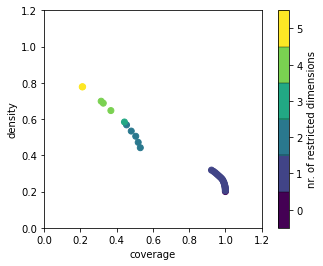

In [13]:
box1.show_tradeoff()
plt.show

In this plot, it is visible that the box has a coverage of almost a little above 0.2. It therefore explains around 20% of the cases of interest. The density is 1, which means that all cases in the box are cases of interest, and nothing else. You can inspect any point in the curve by using the inspect method on the box. This is executed below.

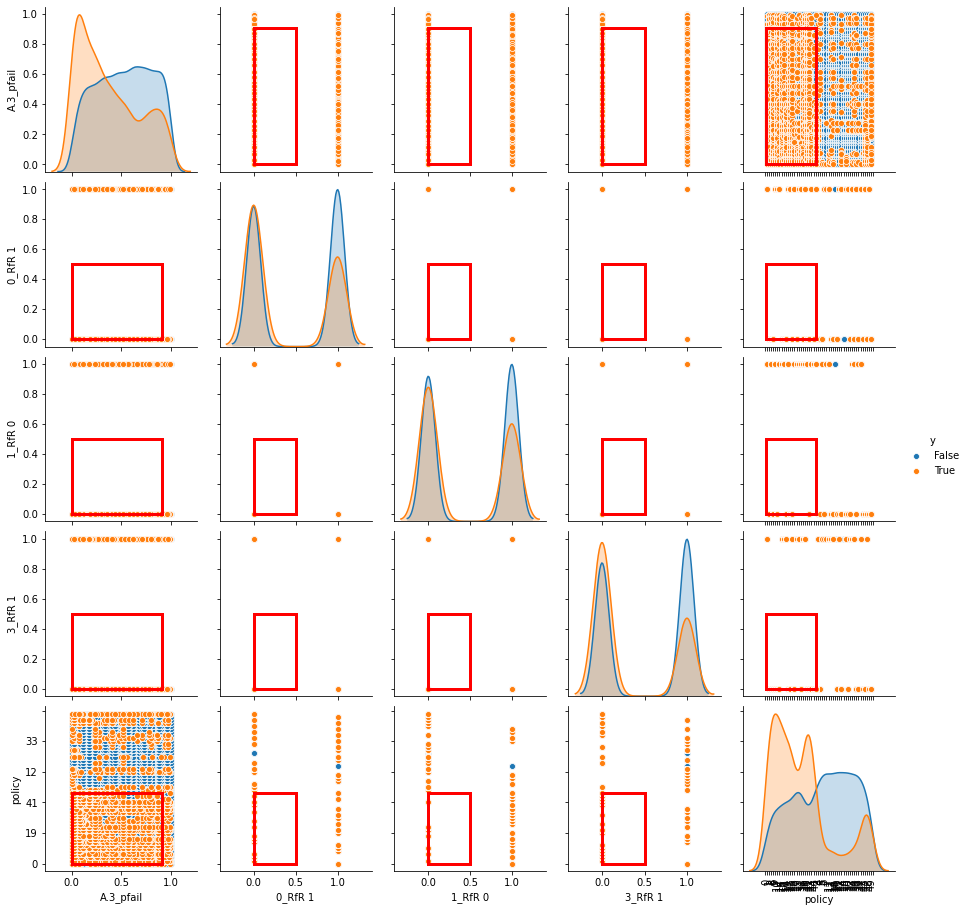

In [14]:
box1.show_pairs_scatter()
# plt.savefig('./results/box1pairsscatter_Rijks_P_randomsampling.jpg', bbox_inches="tight")

plt.show()

This pairs scatter plot shows the ranges of the pfail uncertainties and the range in which there are outcomes of interest, and in which there aren't. It is interesting to see that if A.3_Dike Increase is low, the outcomes are often in the worst case 80 perentile range (orange dots).

coverage      0.3144
density     0.698667
id                30
mass            0.09
mean        0.698667
res_dim            4
Name: 30, dtype: object

                                                      box 30  \
                                                         min   
1_RfR 0                                                    0   
3_RfR 1                                                    0   
A.3_pfail                                         0.00103797   
policy     {0, 1, 2, 8, 9, 10, 14, 15, 16, 17, 19, 23, 25...   

                                                              \
                                                         max   
1_RfR 0                                                  0.5   
3_RfR 1                                                  0.5   
A.3_pfail                                           0.900022   
policy     {0, 1, 2, 8, 9, 10, 14, 15, 16, 17, 19, 23, 25...   

                                           
                                qp 

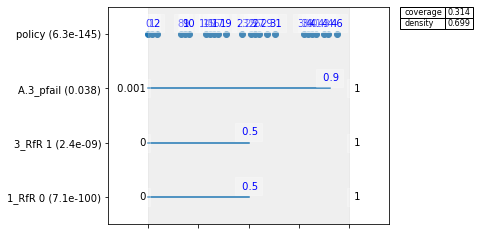

In [15]:
# Show characteristics of the uncertainties in the box
box1.inspect(30)
box1.inspect(30, style='graph')
plt.show()

In [16]:
# Select experiments and show them
selected_experiments = experiments.iloc[box1.yi]
selected_experiments

A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
250                      127.0  237.843044       1.0   0.931498  321.517120   
251                       26.0  188.409051       1.5   0.663340   66.471071   
253                       15.0  148.587021       1.5   0.628690  337.238115   
254                       82.0   96.223527       1.5   0.479539   37.701638   
255                       77.0  275.557026      10.0   0.318023  315.495672   
...                        ...         ...       ...        ...         ...   
10494                    100.0  239.919842       1.5   0.523818  165.858148   
10495                     24.0  232.945508      10.0   0.315375   55.273448   
10497                      4.0   50.760634       1.5   0.691757  260.123399   
10498                     65.0  311.463122       1.5   0.643961  126.067143   
10499                     71.0  250.022803      10.0   0.230724  242.932852   

      A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
250         1.0   0.239127  185.780793       1.0   0.607330  ...   
251         1.0   0.619709  331.559291      10.0   0.529344  ...   
253         1.5   0.027454  136.359048      10.0   0.223969  ...   
254         1.5   0.730923  207.449317       1.5   0.586327  ...   
255         1.5   0.788220  347.575941       1.5   0.108688  ...   
...         ...        ...         ...       ...        ...  ...   
10494      10.0   0.572624   94.730842       1.0   0.780636  ...   
10495      10.0   0.806061  223.016341       1.5   0.174292  ...   
10497       1.5   0.822008  143.361624       1.5   0.115498  ...   
10498      10.0   0.433921   30.112689       1.5   0.566320  ...   
10499      10.0   0.712903  167.607529       1.0   0.730555  ...   

       A.3_DikeIncrease 2 A.4_DikeIncrease 0  A.4_DikeIncrease 1  \
250                   8.0                3.0                 4.0   
251                   8.0                3.0                 4.0   
253                   8.0                3.0                 4.0   
254                   8.0                3.0                 4.0   
255                   8.0                3.0                 4.0   
...                   ...                ...                 ...   
10494                 3.0               10.0                 7.0   
10495                 3.0               10.0                 7.0   
10497                 3.0               10.0                 7.0   
10498                 3.0               10.0                 7.0   
10499                 3.0               10.0                 7.0   

       A.4_DikeIncrease 2 A.5_DikeIncrease 0  A.5_DikeIncrease 1  \
250                   7.0                0.0                 6.0   
251                   7.0                0.0                 6.0   
253                   7.0                0.0                 6.0   
254                   7.0                0.0                 6.0   
255                   7.0                0.0                 6.0   
...                   ...                ...                 ...   
10494                 8.0                2.0                 8.0   
10495                 8.0                2.0                 8.0   
10497                 8.0                2.0                 8.0   
10498                 8.0                2.0                 8.0   
10499                 8.0                2.0                 8.0   

      A.5_DikeIncrease 2 EWS_DaysToThreat policy     model  
250                  1.0              0.0      1  dikesnet  
251                  1.0              0.0      1  dikesnet  
253                  1.0              0.0      1  dikesnet  
254                  1.0              0.0      1  dikesnet  
255                  1.0              0.0      1  dikesnet  
...                  ...              ...    ...       ...  
10494                3.0              1.0     41  dikesnet  
10495                3.0              1.0     41  dikesnet  
10497                3.0              1.0     41  dikesnet

In [17]:
selected_experiments.policy.unique()

[1, 8, 41]
Categories (3, int64): [1, 8, 41]

### 5 | Feature Scoring
Feature scoring is conducted to find out which factors influence the outcomes of interest the most, to see which factors should be prioritized in policy making.

***

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


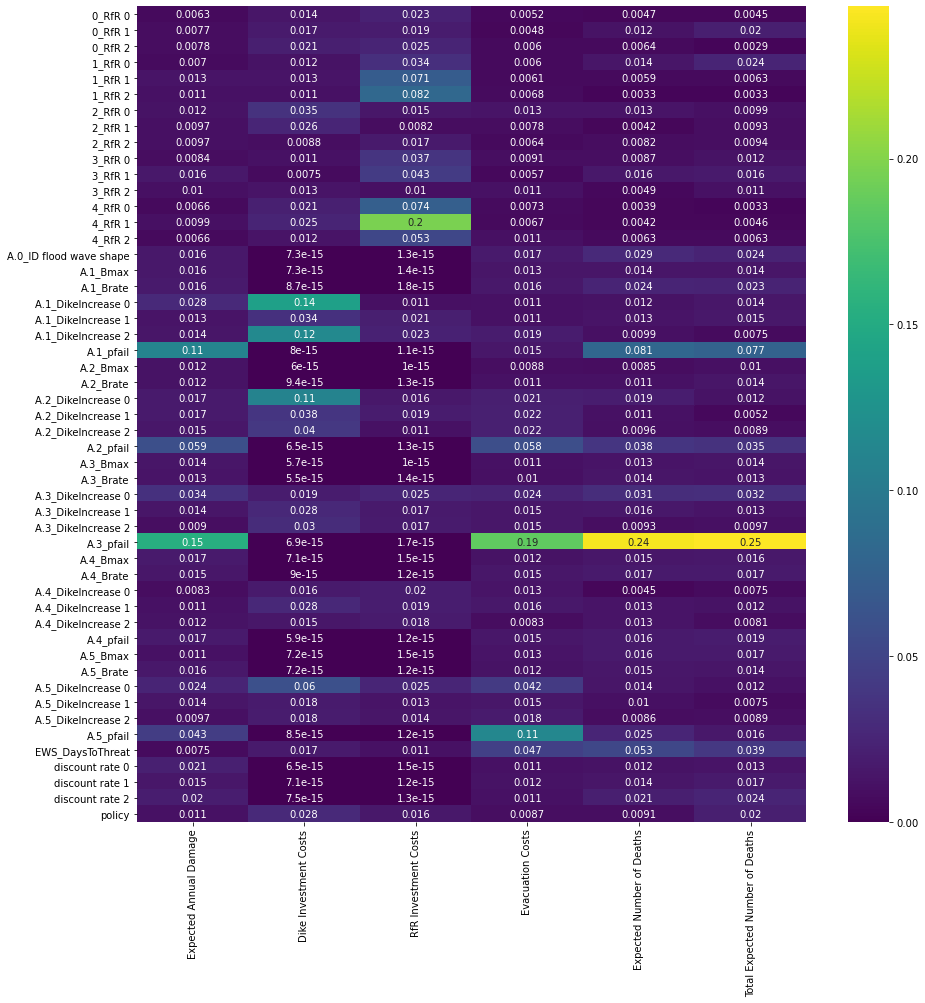

In [18]:
experiments, outcomes = results

from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
fig = plt.gcf()
fig.set_size_inches(15,15)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

### 6 | Regional sensitivity analysis

***

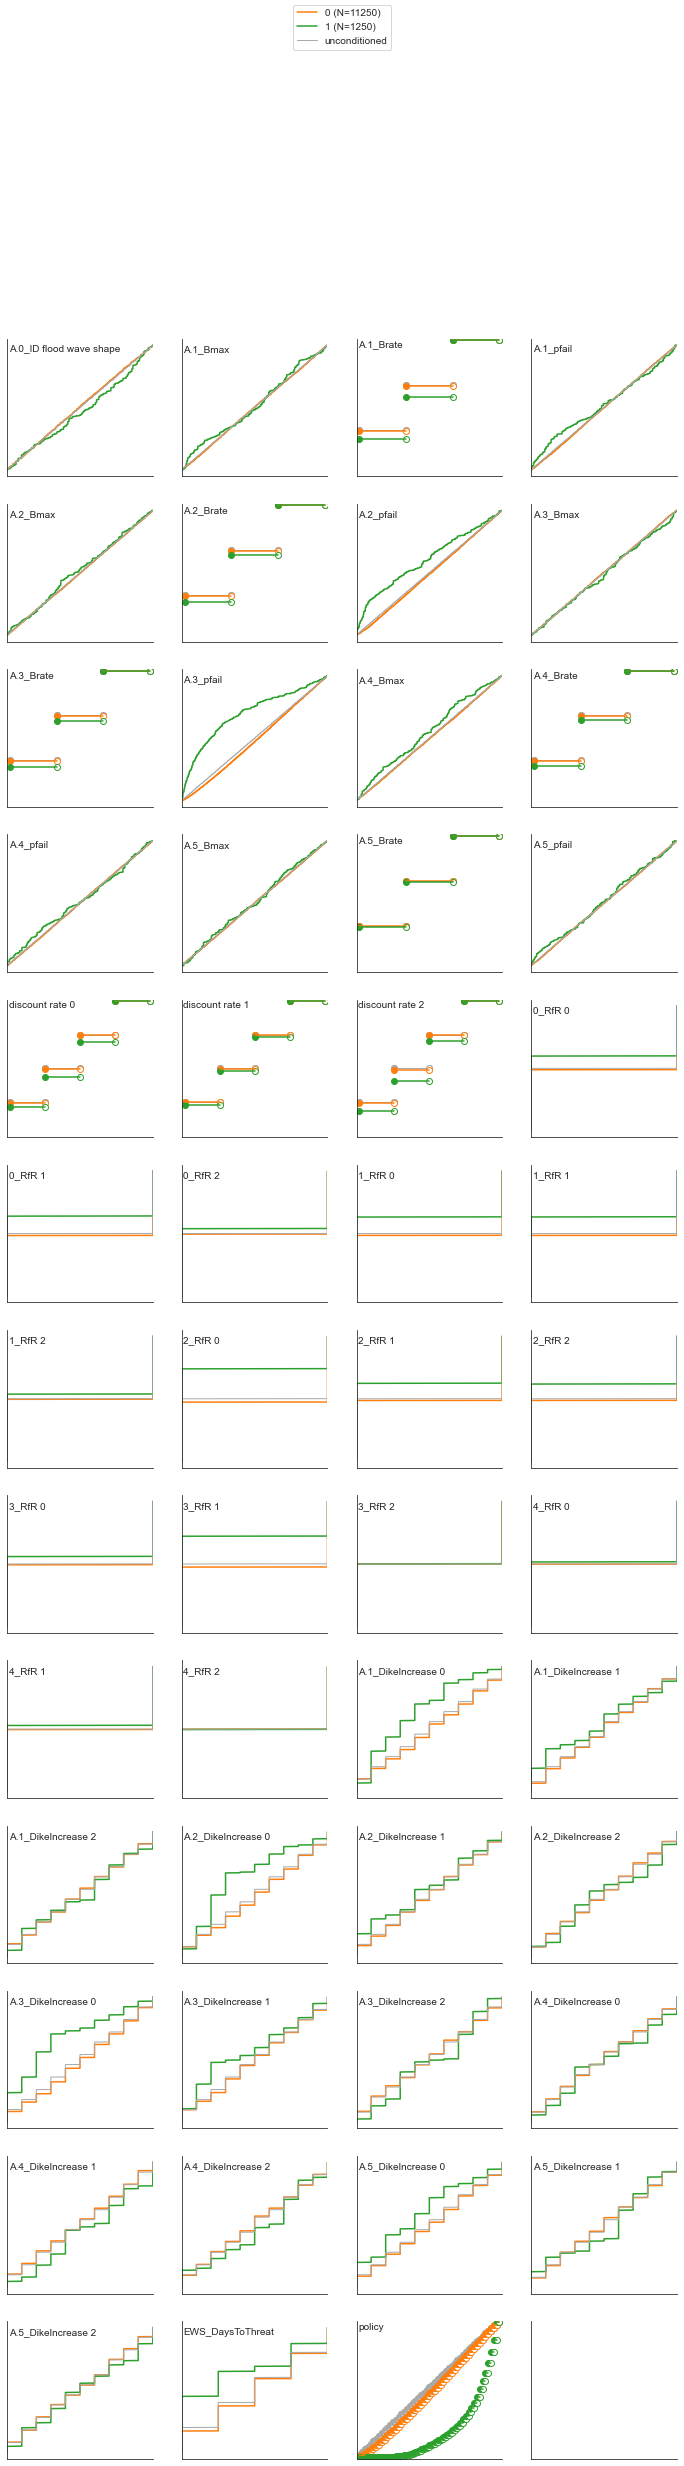

In [19]:
sns.set_style('white')

x = experiments.copy()
x = x.drop('model', axis=1)
y = outcomes['Total Expected Number of Deaths'] >= np.percentile(outcomes['Total Expected Number of Deaths'],90)
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
# plt.savefig('./results/regionalsensitivitydeaths_Zutphen_randomsampling.jpg', bbox_inches="tight")
plt.show()